# Analysis of gapped reads in 10X scRNA sequencing data
This Python Jupyter notebook examines where the 10X aligned FASTQ reads fall on the viral genes (coverage). After identifying large gaps in many reads, I estimate the size of the molecules those gaps come from, as well as check for common sequence motifs related to the gaps.

## Notebook Setup
### Parameters
First, set the parameters for the notebook, such as to specify the input files and output plots.
This is done in the next cell, which is tagged as a `parameters` cell to enable [papermill parameterization](https://papermill.readthedocs.io/en/latest/usage-parameterize.html):

In [1]:
# parameters cell; in order for notebook to run this cell must define:
#  - samples_10x: list of 10X samples
#  - input_fastq10x_bams: list of BAM file with alignments of 10X reads for each sample
#  - input_fastq10x_bais: BAM indices for each file in `input_fastq10x_bam`
#  - input_viral_genbank: Genbank file with annotated viral genes
#  - input_viraltag_locs: output file with location of viral tags (1, ..., numbering)
#  - input_viralbc_locs: output file with location of viral barcodes (1, ..., numbering)
#  - output_gapped_reads: output file with reads annotated as gapped, paired with cell bc information
#  - output_gapped_reads_summary: output file with counts of gapped reads grouped by cell barcode and gene

Check input lists all the right length, then make dicts that map sample names to BAM and BAM index files:

In [3]:
assert len(samples_10x) == len(input_fastq10x_bams) == len(input_fastq10x_bais)

fastq10x_bams = dict(zip(samples_10x, input_fastq10x_bams))
fastq10x_bais = dict(zip(samples_10x, input_fastq10x_bais))

### Import Python modules
We use [pysam](https://pysam.readthedocs.io/) to plot process the BAM files, [dna_features_viewer](https://edinburgh-genome-foundry.github.io/DnaFeaturesViewer/) for genes, and [plotnine](https://plotnine.readthedocs.io/) for some ggplot2-style plotting:

In [4]:
import collections
import itertools

import Bio.SeqIO

from IPython.display import display, HTML

import mizani

import pandas as pd

from plotnine import *

from pymodules.plot_viral_genes import plot_genes_and_coverage

import pysam

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Color-blind palette:

In [5]:
cbpalette = ('#999999', '#E69F00', '#56B4E9', '#009E73',
             '#F0E442', '#0072B2', '#D55E00', '#CC79A7')

Set [plotnine theme](https://plotnine.readthedocs.io/en/stable/api.html#themes):

In [6]:
_ = theme_set(theme_classic)

### Read the viral genes
Get all the viral genes as [BioPython SeqRecords](https://biopython.org/wiki/SeqRecord):

In [7]:
print(f"Reading viral genes from {input_viral_genbank}")
viral_genes = list(Bio.SeqIO.parse(input_viral_genbank, 'genbank'))
viral_gene_names = [s.id for s in viral_genes]
print(f"Found {len(viral_gene_names)} viral genes:\n\t" +
      '\n\t'.join(viral_gene_names))
assert len(viral_genes) == len(set(viral_gene_names)), 'viral gene names not unique'

Reading viral genes from data/flu_sequences/flu-CA09.gb
Found 8 viral genes:
	fluPB2
	fluPB1
	fluPA
	fluHA
	fluNP
	fluNA
	fluM
	fluNS


### Get viral tag and barcode locations
Load viral tag and barcode locations from previously constructed CSVs. These CSVs are generated by the `viral_fastq_10x_coverage` notebook.

In [8]:
print(f"Reading viral barcode locations from {input_viralbc_locs}")
viralbc_locs_df = pd.read_csv(input_viralbc_locs)
viralbc_locs_df

print(f"Reading viral tag locations from {input_viraltag_locs}")
viraltag_locs_df = pd.read_csv(input_viraltag_locs)
viraltag_locs_df

Reading viral barcode locations from results/viral_fastq10x/viralbc_locs.csv
Reading viral tag locations from results/viral_fastq10x/viraltag_locs.csv


,gene,tag_name,start,end
0,fluPB2,viral_tag_1,201,201
1,fluPB2,viral_tag_2,2190,2190
2,fluPB1,viral_tag_1,192,192
3,fluPB1,viral_tag_2,2205,2205
4,fluPA,viral_tag_1,123,123
5,fluPA,viral_tag_2,2104,2104
6,fluHA,viral_tag_1,249,249
7,fluHA,viral_tag_2,1686,1686
8,fluNP,viral_tag_1,132,132
9,fluNP,viral_tag_2,1407,1407


## Calculations

### Optimize gap threshold size
What are the common gap sizes are in our data? I want to see how calling of gapped reads responds to changing the gap size threshold (the number of bases that must be deleted or spliced for a read to be considered gapped).

To address this, I will caclulate how many reads are classified as "gapped" for fluHA and fluNA segments with a variety of gap size thresholds. I will plot these for each segment and each sample.

In [9]:
# count a read as contributing to `gapped_coverage_list` if it has at
# least this many gapped sites (deletion or intron operations)
gapped_sites_threshold = [1,2,5,10,20,100,500,1000]
gap_threshold_list = []

for threshold in gapped_sites_threshold:

    for viral_gene, sample10x in itertools.product(viral_genes, samples_10x):
        gene_name = viral_gene.id
        if gene_name in ['fluHA', 'fluNA']:
            bam = fastq10x_bams[sample10x]
            bai = fastq10x_bais[sample10x]
            print(f"Calculating number of gapped reads in {gene_name} from {sample10x} using a "
                  f"threshold of {threshold} deleted bases.")

            with pysam.AlignmentFile(bam, mode='rb', index_filename=bai) as bamfile:
                if len(viral_gene) != bamfile.get_reference_length(gene_name):
                    raise ValueError(f"length of {gene_name} not as expected in {bam}")

                read_lens = collections.defaultdict(int)
                n_gapped_reads = 0
                for read in bamfile.fetch(contig=gene_name):
                    read_lens[read.query_alignment_length] += 1
                    cs = read.cigarstring
                    if ((('D' in cs) or ('N' in cs)) and (sum(read.get_cigar_stats()[0][2: 4]) >=
                                                          threshold)):
                        n_gapped_reads += 1

                gap_threshold_list.append(
                        pd.DataFrame({'gene': [gene_name],
                                      'sample': [sample10x],
                                      'threshold': threshold,
                                      'n_reads': [bamfile.count(contig=gene_name)],
                                      'n_gapped_reads': [n_gapped_reads],
                                      })
                        )


gap_threshold_df = (pd.concat(gap_threshold_list, sort=False, ignore_index=True)
             .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                   ['fluHA','fluNA'],
                                                   ordered=True))
             )
print('\n`gap_threshold_df`:')
display(HTML(gap_threshold_df.head().to_html(index=False)))

Calculating number of gapped reads in fluHA from hashing_wt_rapidpilot using a threshold of 1 deleted bases.
Calculating number of gapped reads in fluHA from hashing_trial1 using a threshold of 1 deleted bases.
Calculating number of gapped reads in fluHA from hashing_trial2 using a threshold of 1 deleted bases.
Calculating number of gapped reads in fluHA from hashing_trial3_withNH4Cl using a threshold of 1 deleted bases.
Calculating number of gapped reads in fluHA from hashing_trial3_noNH4Cl using a threshold of 1 deleted bases.
Calculating number of gapped reads in fluNA from hashing_wt_rapidpilot using a threshold of 1 deleted bases.
Calculating number of gapped reads in fluNA from hashing_trial1 using a threshold of 1 deleted bases.
Calculating number of gapped reads in fluNA from hashing_trial2 using a threshold of 1 deleted bases.
Calculating number of gapped reads in fluNA from hashing_trial3_withNH4Cl using a threshold of 1 deleted bases.
Calculating number of gapped reads in fl

Calculating number of gapped reads in fluNA from hashing_trial3_withNH4Cl using a threshold of 1000 deleted bases.
Calculating number of gapped reads in fluNA from hashing_trial3_noNH4Cl using a threshold of 1000 deleted bases.

`gap_threshold_df`:


gene,sample,threshold,n_reads,n_gapped_reads
fluHA,hashing_wt_rapidpilot,1,14880,504
fluHA,hashing_trial1,1,120650,13115
fluHA,hashing_trial2,1,158043,55466
fluHA,hashing_trial3_withNH4Cl,1,185263,82366
fluHA,hashing_trial3_noNH4Cl,1,135798,53671


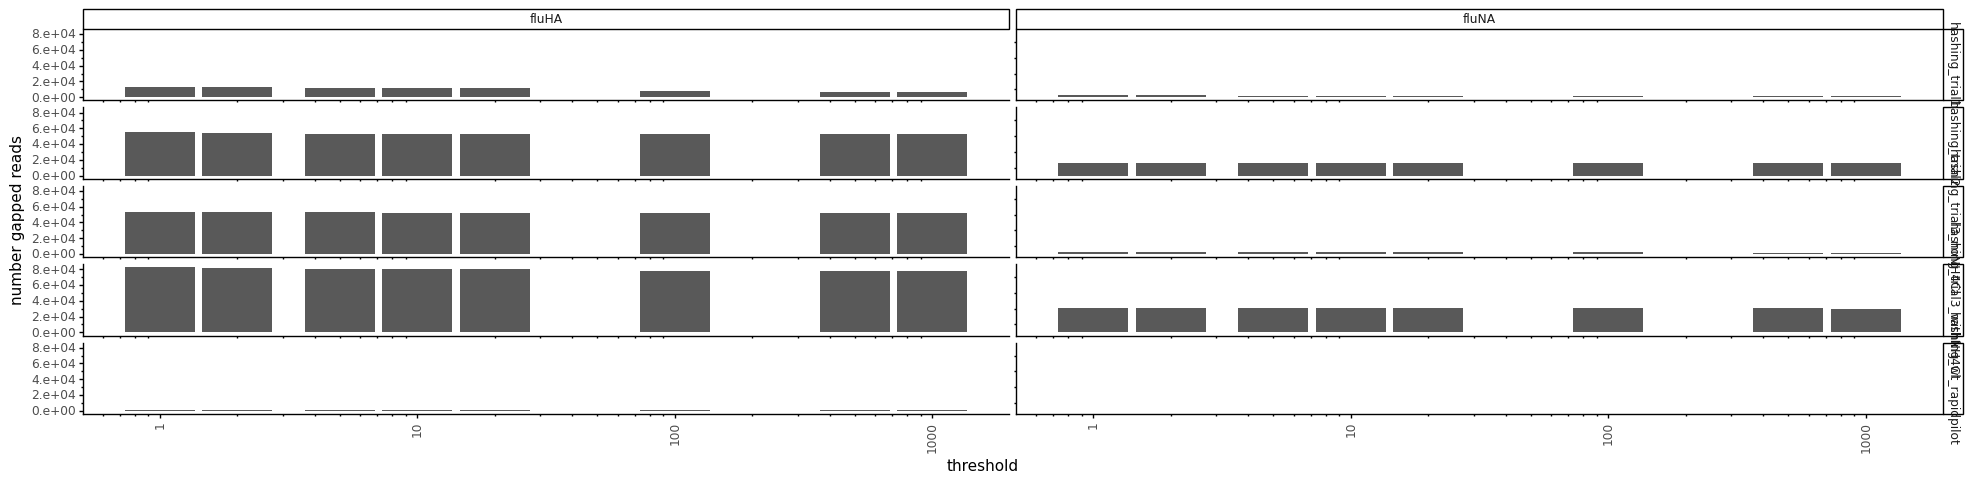

In [10]:
p = (ggplot(gap_threshold_df, aes('threshold', 'n_gapped_reads')) +
     geom_bar(stat='identity') +
     facet_grid('sample~gene') +
     theme(figure_size=(0.3 * len(gap_threshold_df.gene), 5),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format(),
                        name='number gapped reads') +
     scale_x_log10()
     )

_ = p.draw()

**Interpretation:**  It looks like there are two classes of deletions in the fluHA reads. There is one class of deletions that fall between 1 and 20 bp. There is another class of deletions that are larger than 20 bp.

There is only one class of deletions in the fluNA reads. They are nearly all at least 1000 kb long.

Based on these results, I think it is **reasonable to use any threshold less than 20 bp.** I will continue using 10 bp.

### Get alignment statistics for each gene and sample

Use [pysam](https://pysam.readthedocs.io/) to get the following dataframes:
 - `nreads_df`: total number of reads aligned to each gene in each sample, and total number of reads with gaps.
 - `coverage_df`: coverage at each site for each viral gene in each sample
 - `read_len_df`: distribution of lengths of the **aligned** portion of reads (not including soft-clipped bases) for each gene in each sample
 - `gapped_coverage_df`: like `coverage_df` but only includes reads with a gap.
 - `gapped_reads_df`: has dettailed information (including cigar string and read sequence) for each gapped read.
 
In computing these statistics, a read is considered to have a gap if it has a substantial number of sites (set by the `gapped_sites_threshold` variable below) that are gapped in the alignment.
Gaps are considered anything annotated as either a `D` (deletion) or `N` (intron) in the cigar string.
The rationale is that reads with reasonably long gaps might be spanning internal deletion junctions in viral genes.

In [11]:
def robust_get_tag(read, tag, default_value=None):  
 try:  
   return read.get_tag(tag)
 except KeyError:
   return default_value

# count a read as contributing to `gapped_coverage_list` if it has at
# least this many gapped sites (deletion or intron operations)
gapped_sites_threshold = 10
clipped_sites_threshold = 4

coverage_list = []
nreads_list = []
read_len_list = []
molecule_size_list = []
gapped_coverage_list = []
gapped_reads_list = []

for viral_gene, sample10x in itertools.product(viral_genes, samples_10x):
    gene_name = viral_gene.id
    bam = fastq10x_bams[sample10x]
    bai = fastq10x_bais[sample10x]
    print(f"Getting statistics for {gene_name} in {sample10x} from {bam}")

    with pysam.AlignmentFile(bam, mode='rb', index_filename=bai) as bamfile:
        if len(viral_gene) != bamfile.get_reference_length(gene_name):
            raise ValueError(f"length of {gene_name} not as expected in {bam}")

        coverage_list.append(
                pd.DataFrame(dict(zip('ACGT',
                                      bamfile.count_coverage(contig=gene_name))))
                .assign(coverage=lambda x: x.sum(axis=1),
                        site=lambda x: x.index + 1,
                        gene=gene_name,
                        sample=sample10x)
                )

        read_lens = collections.defaultdict(int)
        molecule_sizes = collections.defaultdict(int)
        n_gapped_reads = 0
        n_softclipped_reads = 0
        gapped_coverage = collections.Counter({i:0 for i in range(len(viral_gene))})
        for read in bamfile.fetch(contig=gene_name):
            read_lens[read.query_alignment_length] += 1
            cs = read.cigarstring
            gap_size = sum(read.get_cigar_stats()[0][2: 4])
            estimated_molecule_size = len(viral_gene) - gap_size
            molecule_sizes[estimated_molecule_size] += 1
            if (('D' in cs) or ('N' in cs)) and (gap_size >= gapped_sites_threshold):
                gapped_coverage.update(read.get_reference_positions())
                n_gapped_reads += 1
                gapped_reads_list.append(
                    pd.DataFrame({'read_id': read.query_name,
                                  'sample': [sample10x],
                                  'gene': [gene_name],
                                  'cell_bc': robust_get_tag(read,tag='CB'),
                                  'start_position': min(read.get_reference_positions()),
                                  'end_position': max(read.get_reference_positions()),
                                  'cigar_string': read.cigarstring,
                                  'num_deletions': read.cigarstring.count('N') + read.cigarstring.count('D'),
                                  'read_sequence': read.get_forward_sequence()
                                }))
            
                        
        nreads_list.append(
                pd.DataFrame({'gene': [gene_name],
                              'sample': [sample10x],
                              'n_reads': [bamfile.count(contig=gene_name)],
                              'n_gapped_reads': [n_gapped_reads],
                              })
                ) 

        read_len_list.append(
                pd.DataFrame.from_records(list(read_lens.items()),
                                          columns=['aligned_read_length', 'nreads'])
                .assign(gene=gene_name,
                        sample=sample10x)
                .sort_values('aligned_read_length')
                [['gene', 'sample', 'aligned_read_length', 'nreads']]
                )
                                                   
        molecule_size_list.append(
                pd.DataFrame.from_records(list(molecule_sizes.items()),
                                          columns=['estimated_molecule_size', 'nreads'])
                .assign(gene=gene_name,
                        sample=sample10x)
                .sort_values('estimated_molecule_size')
                [['gene', 'sample', 'estimated_molecule_size', 'nreads']]
                )

        gapped_coverage_list.append(
                pd.DataFrame.from_records(list(gapped_coverage.items()),
                                          columns=['site', 'coverage'])
                .assign(site=lambda x: x['site'] + 1,
                        gene=gene_name,
                        sample=sample10x)
                [['gene', 'sample', 'site', 'coverage']]
                )


nreads_df = (pd.concat(nreads_list, sort=False, ignore_index=True)
             .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                   viral_gene_names,
                                                   ordered=True))
             )
print('\n`nreads_df`:')
display(HTML(nreads_df.to_html(index=False)))

coverage_df = (pd.concat(coverage_list, sort=False, ignore_index=True)
               .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                     viral_gene_names,
                                                     ordered=True))
               )
print('\nFirst few lines of `coverage_df`:')
display(HTML(coverage_df.head().to_html(index=False)))

gapped_coverage_df = (pd.concat(gapped_coverage_list, sort=False,
                                ignore_index=True)
                      .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                            viral_gene_names,
                                                            ordered=True))
                      )
print('\nFirst few lines of `gapped_coverage_df`:')
display(HTML(gapped_coverage_df.head().to_html(index=False)))

read_len_df = (pd.concat(read_len_list, sort=False, ignore_index=True)
              .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                    viral_gene_names,
                                                    ordered=True))
              )
print('\nFirst few lines of `read_len_df`:')
display(HTML(read_len_df.head().to_html(index=False)))

molecule_size_df = (pd.concat(molecule_size_list, sort=False, ignore_index=True)
              .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                    viral_gene_names,
                                                    ordered=True))
              )
print('\nLast few lines of `molecule_size_df`:')
display(HTML(molecule_size_df.tail().to_html(index=False)))

gapped_reads_df = (pd.concat(gapped_reads_list, sort=False,
                                ignore_index=True)
                      .assign(gene=lambda x: pd.Categorical(x['gene'],
                                                            viral_gene_names,
                                                            ordered=True))
                      )

# Export gapped_reads_df to CSV for integration into gene_analysis
gapped_reads_df.to_csv(output_gapped_reads)

print('\nFirst few lines of `gapped_reads_df`:')
display(HTML(gapped_reads_df.head().to_html(index=False)))

Getting statistics for fluPB2 in hashing_wt_rapidpilot from results/aligned_fastq10x/hashing_wt_rapidpilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluPB2 in hashing_trial1 from results/aligned_fastq10x/hashing_trial1/Aligned.sortedByCoord.out.bam
Getting statistics for fluPB2 in hashing_trial2 from results/aligned_fastq10x/hashing_trial2/Aligned.sortedByCoord.out.bam
Getting statistics for fluPB2 in hashing_trial3_withNH4Cl from results/aligned_fastq10x/hashing_trial3_withNH4Cl/Aligned.sortedByCoord.out.bam
Getting statistics for fluPB2 in hashing_trial3_noNH4Cl from results/aligned_fastq10x/hashing_trial3_noNH4Cl/Aligned.sortedByCoord.out.bam
Getting statistics for fluPB1 in hashing_wt_rapidpilot from results/aligned_fastq10x/hashing_wt_rapidpilot/Aligned.sortedByCoord.out.bam
Getting statistics for fluPB1 in hashing_trial1 from results/aligned_fastq10x/hashing_trial1/Aligned.sortedByCoord.out.bam
Getting statistics for fluPB1 in hashing_trial2 from results/aligned_fastq1

gene,sample,n_reads,n_gapped_reads
fluPB2,hashing_wt_rapidpilot,2311,13
fluPB2,hashing_trial1,16451,261
fluPB2,hashing_trial2,12352,48
fluPB2,hashing_trial3_withNH4Cl,7595,1683
fluPB2,hashing_trial3_noNH4Cl,5365,998
fluPB1,hashing_wt_rapidpilot,6513,5
fluPB1,hashing_trial1,55543,131
fluPB1,hashing_trial2,34179,64
fluPB1,hashing_trial3_withNH4Cl,13151,812
fluPB1,hashing_trial3_noNH4Cl,8550,513



First few lines of `coverage_df`:


A,C,G,T,coverage,site,gene,sample
34,0,0,0,34,1,fluPB2,hashing_wt_rapidpilot
0,0,90,0,90,2,fluPB2,hashing_wt_rapidpilot
0,87,0,0,87,3,fluPB2,hashing_wt_rapidpilot
0,0,91,0,91,4,fluPB2,hashing_wt_rapidpilot
89,0,0,0,89,5,fluPB2,hashing_wt_rapidpilot



First few lines of `gapped_coverage_df`:


gene,sample,site,coverage
fluPB2,hashing_wt_rapidpilot,1,0
fluPB2,hashing_wt_rapidpilot,2,0
fluPB2,hashing_wt_rapidpilot,3,0
fluPB2,hashing_wt_rapidpilot,4,0
fluPB2,hashing_wt_rapidpilot,5,0



First few lines of `read_len_df`:


gene,sample,aligned_read_length,nreads
fluPB2,hashing_wt_rapidpilot,81,31
fluPB2,hashing_wt_rapidpilot,82,24
fluPB2,hashing_wt_rapidpilot,83,17
fluPB2,hashing_wt_rapidpilot,84,9
fluPB2,hashing_wt_rapidpilot,85,8



Last few lines of `molecule_size_df`:


gene,sample,estimated_molecule_size,nreads
fluNS,hashing_trial3_noNH4Cl,886,3
fluNS,hashing_trial3_noNH4Cl,887,3
fluNS,hashing_trial3_noNH4Cl,888,54
fluNS,hashing_trial3_noNH4Cl,889,776
fluNS,hashing_trial3_noNH4Cl,890,221160



First few lines of `gapped_reads_df`:


read_id,sample,gene,cell_bc,start_position,end_position,cigar_string,num_deletions,read_sequence
M03100:504:000000000-CNCN9:1:1115:27838:16851,hashing_wt_rapidpilot,fluPB2,AGGTTACGTAGTTAGA,45,2298,81M2132N41M,1,CTGAGAGATCTAATGTCGCAGTCCCGCACTCGCGAGATACTCACTAAGACCACTGTGGACCATATGGCCATAATCAAAAAGTACTGACAGCCAGACAGCGACCAAAAGAATTCGGATGGCCA
M03100:504:000000000-CNCN9:1:2114:27472:18763,hashing_wt_rapidpilot,fluPB2,GACCCTTGTGCGAACA,94,486,60M271N62M,1,CCACTGTGGACCATATGGCCATAATCAAAAAGTACACATCAGGAAGGCAAGAGAAGAACCCCACTTCAGAAATCAAGTTAAAATAAGGAGGAGAGTTGATACAAACCCTGGCCATGCAGATC
M03100:504:000000000-CNCN9:1:1115:26530:18252,hashing_wt_rapidpilot,fluPB2,GTAGAAATCGGCCCAA,112,2306,86M2073N36M,1,CCATAATCAAAAAGTACACATCAGGAAGGCAAGAGAAGAACCCCGCACTCAGAATGAAGTGGATGATGGCAATGAGATACCCAATTACAGCGACCAAAAGAATTCGGATGGCCATCAATTAG
M03100:504:000000000-CNCN9:1:1106:15192:15479,hashing_wt_rapidpilot,fluPB2,CTAAGTGCAAAGCTAA,118,2314,89M2075N33M,1,TCAAAAAGTACACATCAGGAAGGCAAGAGAAGAACCCCGCACTCAGAATGAAGTGGATGATGGCAATGAGATACCCAATTACAGCAGACAAGAATTCGGATGGCCATCAATTAGTGTCGAAT
M03100:504:000000000-CNCN9:1:2104:14491:6513,hashing_wt_rapidpilot,fluPB2,GCCAGGTCATCCAATG,120,647,19M406N103M,1,AAAAAGTACACATCAGGAAGGCAAGAATACTGACATCAGAGTCACAGCTGGCAATAACAAAAGAGAAGAAAGAAGAGCTCCAGGATTGTAAAATTGCTCCCTTGATGGTGGCGTACATGCTA


Sanity check to make sure we got the right number of sites for each gene in `coverage_df` and `gapped_coverage_df`:

In [12]:
for viral_gene in viral_genes:
    gene_name = viral_gene.id
    for df in [coverage_df, gapped_coverage_df]:
        df_name = [x for x in globals() if globals()[x] is df][0]
        lengths = (df
                   .query('gene == @gene_name')
                   .groupby('sample')
                   .size()
                   .values
                   )
        if not all(lengths == len(viral_gene)):
            raise ValueError(f"{df_name}: coverage not for expected number sites for {gene_name}.")
        else:
            print(f'{df_name}: {viral_gene.id} passed filter.')

coverage_df: fluPB2 passed filter.
gapped_coverage_df: fluPB2 passed filter.
coverage_df: fluPB1 passed filter.
gapped_coverage_df: fluPB1 passed filter.
coverage_df: fluPA passed filter.
gapped_coverage_df: fluPA passed filter.
coverage_df: fluHA passed filter.
gapped_coverage_df: fluHA passed filter.
coverage_df: fluNP passed filter.
gapped_coverage_df: fluNP passed filter.
coverage_df: fluNA passed filter.
gapped_coverage_df: fluNA passed filter.
coverage_df: fluM passed filter.
gapped_coverage_df: fluM passed filter.
coverage_df: fluNS passed filter.
gapped_coverage_df: fluNS passed filter.


Sanity check to make sure `nreads_df`, `read_len_df`, and `molecule_size_df` have same number of reads:

In [13]:
nreads_n = nreads_df.sort_values(['gene', 'sample'])['n_reads'].values
read_len_n = (read_len_df
             .groupby(['gene', 'sample'])
             .aggregate({'nreads': 'sum'})
             ['nreads']
             .values
             )
molecule_size_n = (molecule_size_df
             .groupby(['gene', 'sample'])
             .aggregate({'nreads': 'sum'})
             ['nreads']
             .values
             )

if not all((nreads_n == read_len_n)) and all((nreads_n == molecule_size_n)) and all((read_len_n == molecule_size_n)):
    raise ValueError('nreads differ for `nreads_df`, `read_len_df`, and `molecule_size_n`')
else:
    print('Pass.')

Pass.


## Plot statistics about reads

### Plot distribution of reads by segment
Plot the number of reads mapping to each segment:

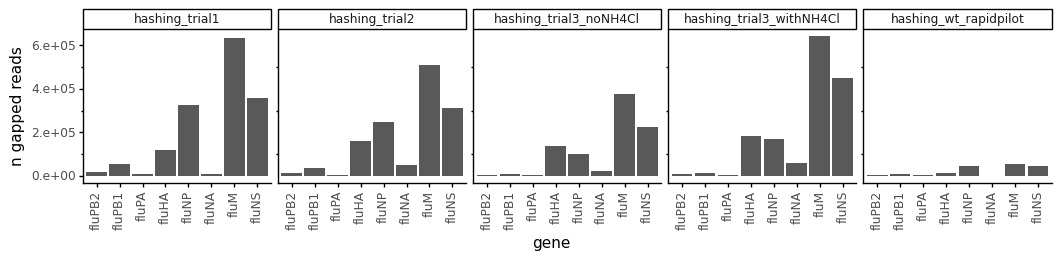

In [14]:
p = (ggplot(nreads_df,
            aes('gene', 'n_reads')) +
     geom_bar(stat='identity') +
     facet_wrap('~ sample', nrow=1) +
     theme(figure_size=(2.5 * len(samples_10x), 2),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format()) +
     ylab('n gapped reads')
     )

_ = p.draw()

### Plot fraction of reads that are gapped
Plot the fraction of all reads that are gapped for each viral gene:

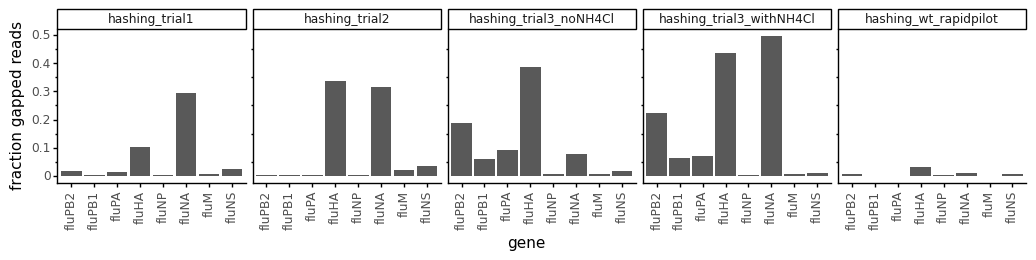

In [15]:
p = (ggplot(nreads_df.assign(frac=lambda x: x['n_gapped_reads'] / x['n_reads']),
            aes('gene', 'frac')) +
     geom_bar(stat='identity') +
     facet_wrap('~ sample', nrow=1) +
     theme(figure_size=(2.5 * len(samples_10x), 2),
           axis_text_x=element_text(angle=90)) +
     ylab('fraction gapped reads')
     )

_ = p.draw()

### Plot lengths of aligned reads for each viral gene
Plot the distribution of the **aligned** lengths of each read for each viral gene:

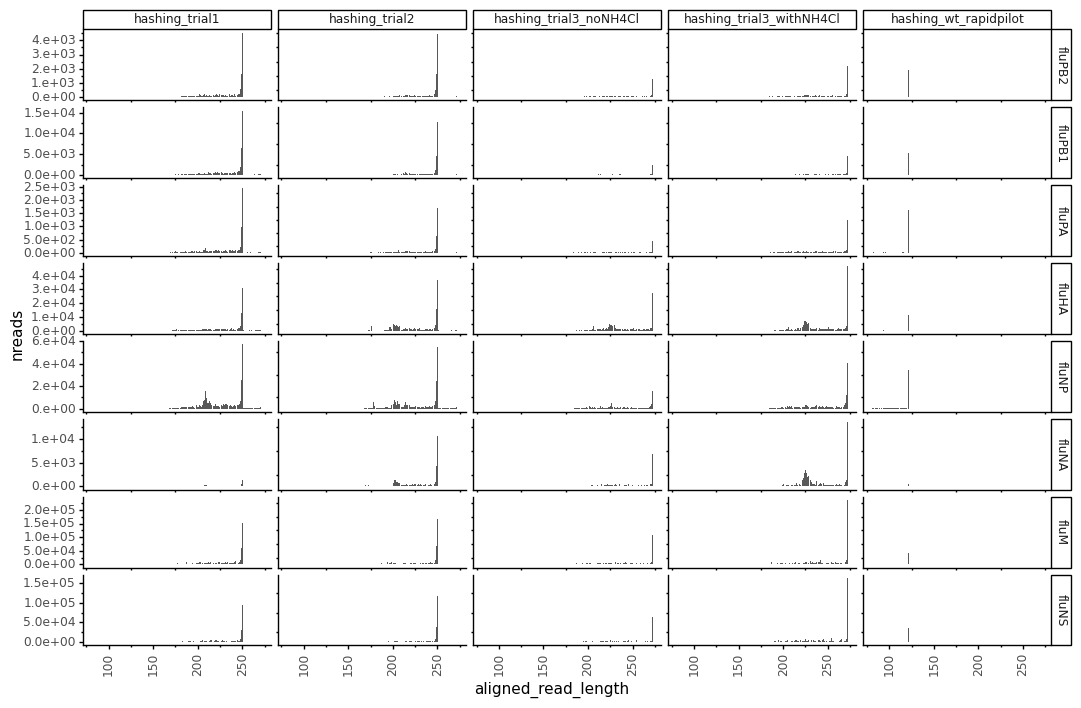

In [16]:
p = (ggplot(read_len_df, aes('aligned_read_length', 'nreads')) +
     geom_bar(stat='identity') +
     facet_grid('gene ~ sample', scales='free_y') +
     theme(figure_size=(2.5 * len(samples_10x), 1 * len(viral_gene_names)),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format())
     )

_ = p.draw()

### Plot estimated molecule sizes for each viral gene
Plot the distribution of the **estimated** mRNA size for each viral gene. This assumes that all portions of the molecule which are not covered by a given read is ungapped.

In the plot below I increased the bar size to 50 nt, to make it easier to see the bars. There are many molecule sizes which have only a handful of reads supporting them. These are not well-represented by the barplot. If you want to see these, they can be visualized by plotting the same data with geom_point().

/fh/fast/bloom_j/software/conda_v2/envs/BloomLab/lib/python3.6/site-packages/plotnine/positions/position.py:204: PlotnineWarning: position_stack requires non-overlapping x intervals
  warn(msg.format(cls.__name__), PlotnineWarning)


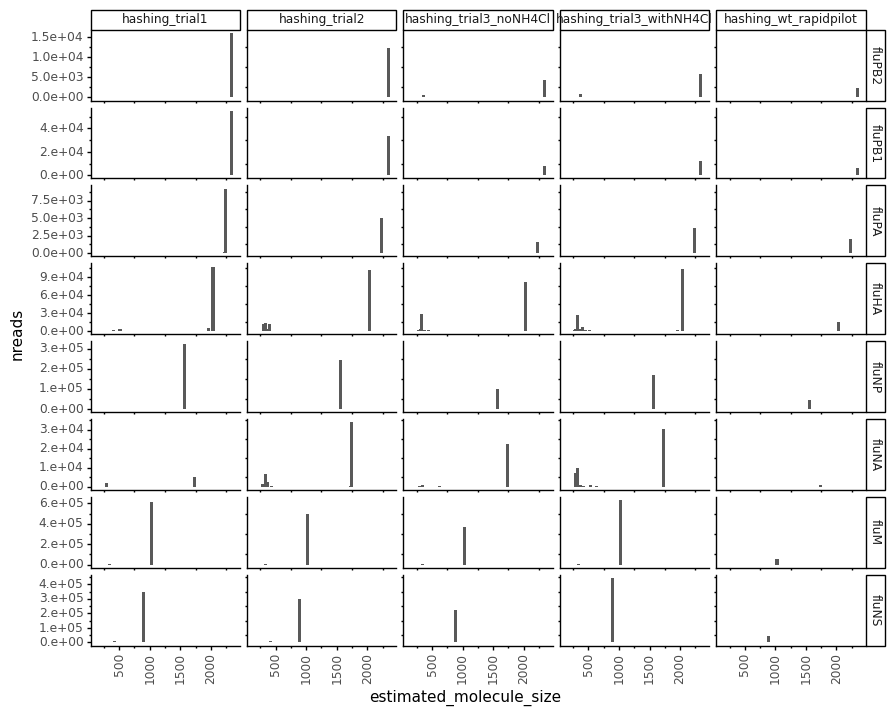

In [17]:
p = (ggplot(molecule_size_df, aes('estimated_molecule_size', 'nreads')) +
     geom_col(width=50) +
     facet_grid('gene ~ sample', scales='free_y') +
     theme(figure_size=(2 * len(samples_10x), 1 * len(viral_gene_names)),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format())
     )

_ = p.draw()

## Plot coverage per site
Now plot coverage per site alongside gene structure.
In these plots, we indicate the viral tags (blue) and viral barcodes (orange):

### Plot coverage of all reads

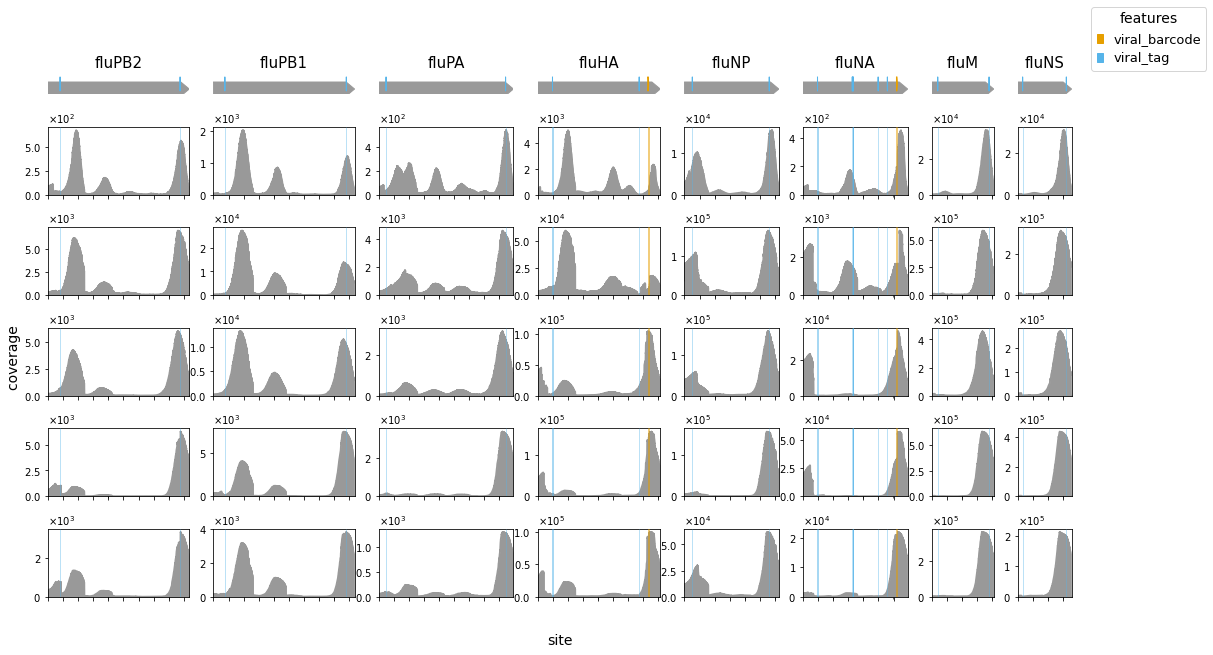

In [18]:
fig, _ = plot_genes_and_coverage(viral_genes, coverage_df)

In the above plot, reads that align not at the 3' end have two likely causes:
 - Premature polyadenylation or mis-priming by oligo-dT primers cause the 3' primer to anneal before the end of the gene.
 - An internal deletion in the viral gene.

We can get some sense of these by plotting the coverage indicating observed mutations (an enrichment of `A` mutations before a peak could indicate the polyA explanation) and coverage only from the gapped reads (which could indicate an internal deletion in the viral gene).

First make the plot showing mutant nucleotides at each site:

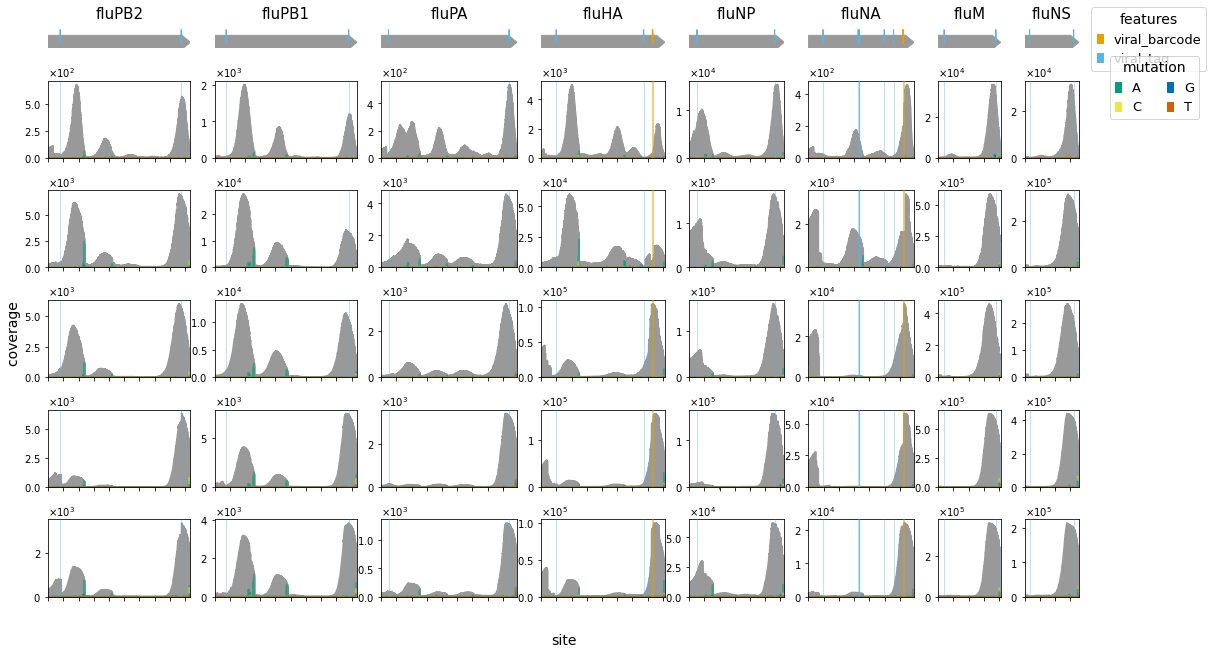

In [19]:
fig, _ = plot_genes_and_coverage(viral_genes, coverage_df, color_mutations=True)

### Plot coverage of gapped reads only
Now plot coverage for **just** the gapped reads:

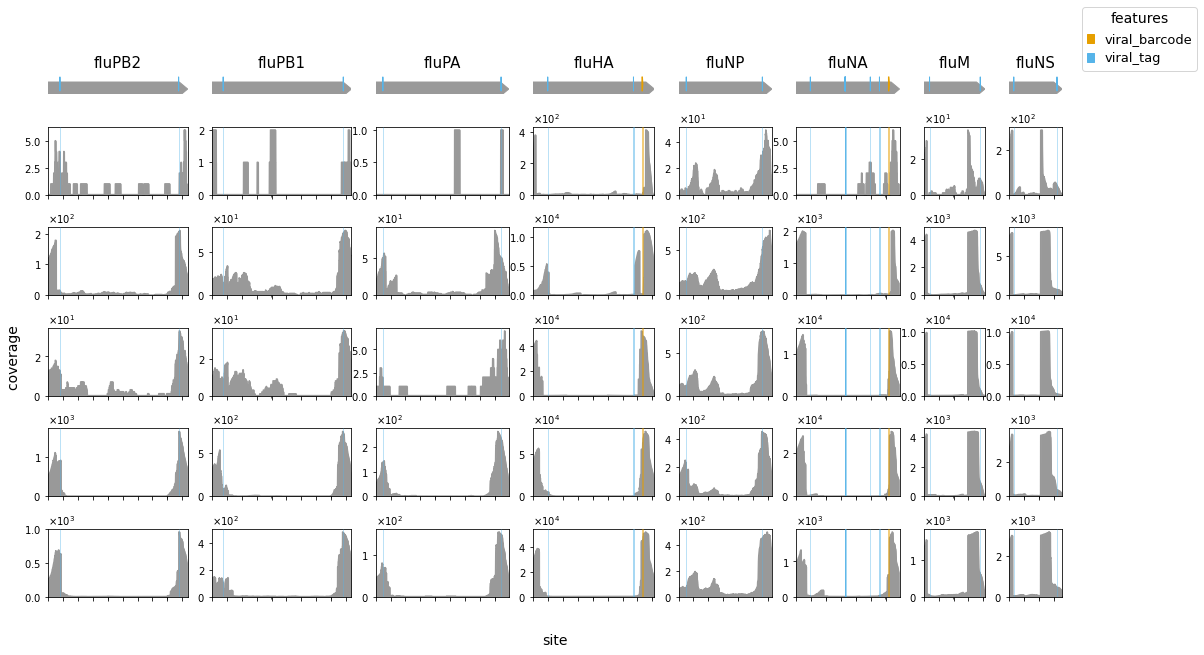

In [20]:
fig, _ = plot_genes_and_coverage(viral_genes, gapped_coverage_df)

**Interpretation:** In most segments, gapped reads show large deletions with sharp junction borders.

## Examining gapped reads
### Number of deletions in gapped reads
Plot the number of gaps in each read.

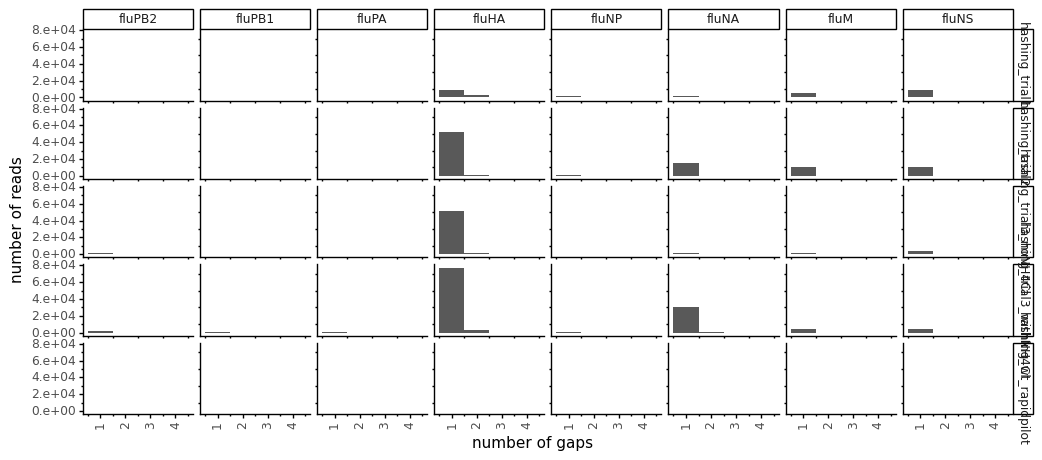

In [21]:
p = (ggplot(gapped_reads_df, aes('num_deletions')) +
     geom_histogram(binwidth=1) +
     facet_grid('sample ~ gene') +
     theme(figure_size=(1.5*len(gapped_reads_df['gene'].unique()), 5),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format(),
                        name='number of reads') +
     scale_x_continuous(name='number of gaps')
     )

_ = p.draw()

**Interpreation:** Most reads with deletions only have a single deletion. The notable exception is fluHA, which commonly has reads with 2 deletions.

### Number and proportion of gapped reads contributed by each cell
Calculate the number and proportion of gapped reads associated with each individual cell barcode.

In [22]:
gapped_reads_summary = gapped_reads_df.groupby(['sample','gene','cell_bc'])['read_id'].count().reset_index(name='nreads')

gapped_reads_summary = pd.merge(gapped_reads_summary, gapped_reads_summary.groupby(['sample','gene']) \
                                .sum().reset_index().rename(columns={'nreads': 'gene_sum'}), on=['sample','gene'])

gapped_reads_summary['nreads_prop_by_gene'] = gapped_reads_summary['nreads']/gapped_reads_summary['gene_sum']

gapped_reads_summary = gapped_reads_summary.sort_values(by='nreads_prop_by_gene', ascending=False)

gapped_reads_summary.to_csv(output_gapped_reads_summmary)

gapped_reads_summary.head()

,sample,gene,cell_bc,nreads,gene_sum,nreads_prop_by_gene
39539,hashing_wt_rapidpilot,fluPA,GATAGAAAGGCTCCCA,1,1,1.000000
2896,hashing_trial1,fluNA,TGCGATAGTGAGTCAG,1672,2086,0.801534
1799,hashing_trial1,fluHA,TGCACGGGTGCGAACA,6990,11851,0.589824
74,hashing_trial1,fluPB2,TATCAGGTCACCCTTG,146,257,0.568093
39594,hashing_wt_rapidpilot,fluHA,TTTCACAGTCCGTACG,242,436,0.555046


### Plot number of gapped reads contributed to each gene by each cell
This graph shows raw number of gapped reads (nreads) that are associated with each cell barcode. Each dot is an individual cell barcode, and the dots are grouped by read.

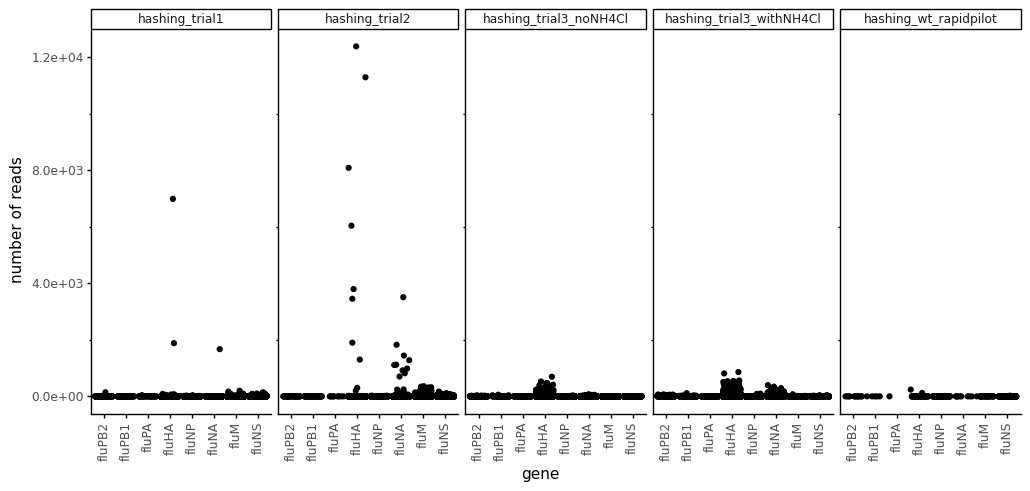

In [23]:
p = (ggplot(gapped_reads_summary, aes(x='gene',y='nreads')) +
    geom_jitter() +
    facet_grid('~sample') +
     theme(figure_size=(1.5*len(gapped_reads_df['gene'].unique()), 5),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format(),
                        name='number of reads')
    )

_ = p.draw()

### Plot proportion of gapped reads contributed to each gene by each cell
This graph shows the proportion of gapped reads for a *given gene* that are associated with each cell barcode. Each dot represents and individual cell barcode.

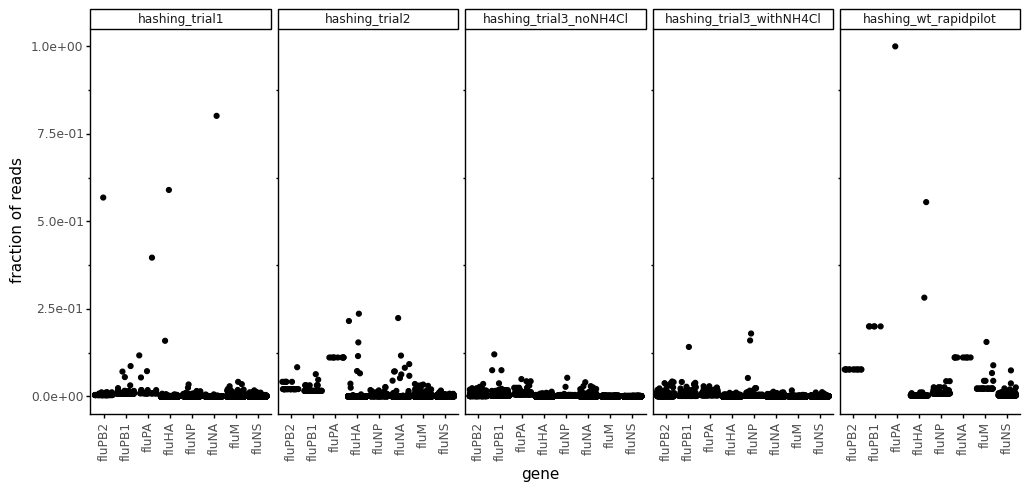

In [24]:
p = (ggplot(gapped_reads_summary, aes(x='gene',y='nreads_prop_by_gene')) +
    geom_jitter()+
    facet_grid('~sample') +
     theme(figure_size=(1.5*len(gapped_reads_df['gene'].unique()), 5),
           axis_text_x=element_text(angle=90)) +
     scale_y_continuous(labels=mizani.formatters.scientific_format(),
                        name='fraction of reads')
    )

_ = p.draw()

### Filter to top 10 cells for each segment
When I try to plot these data as histograms or cumulative density, the script hangs because there are too many individual barcodes in the table to plot efficiently.

I'm really just interested in very large contributions (relative to average). I will subset the dataframe to only include the top 10 cell barcodes for each segment.

In [25]:
gapped_reads_summary_filtered_list = []
for i in range(0,10):
    gapped_reads_summary_filtered_list.append(gapped_reads_summary.groupby(['sample','gene']).nth(i))

gapped_reads_summary_filtered = pd.concat(gapped_reads_summary_filtered_list, sort=False).reset_index()

gapped_reads_summary_filtered = gapped_reads_summary_filtered.sort_values(by=['gene', 'nreads_prop_by_gene'], \
                                                                          ascending=[True, False])

temp = []
for name, group in gapped_reads_summary_filtered.groupby(['sample','gene']):
    group = group.sort_values(by='nreads', ascending=False)
    group['cell_bc_sort'] = list(range(1,len(group)+1))
    temp.append(group)
gapped_reads_summary_filtered = pd.concat(temp)

gapped_reads_summary_filtered.head()

,sample,gene,cell_bc,nreads,gene_sum,nreads_prop_by_gene,cell_bc_sort
0,hashing_trial1,fluPB2,TATCAGGTCACCCTTG,146,257,0.568093,1
40,hashing_trial1,fluPB2,TACCGAACAACAACAA,3,257,0.011673,2
79,hashing_trial1,fluPB2,TCACATTAGTCAATCC,3,257,0.011673,3
118,hashing_trial1,fluPB2,ACGTAGTTCATGTCTT,3,257,0.011673,4
157,hashing_trial1,fluPB2,TATATCCGTACTTCCC,3,257,0.011673,5


### Plot top 10 cell barcodes for each gene

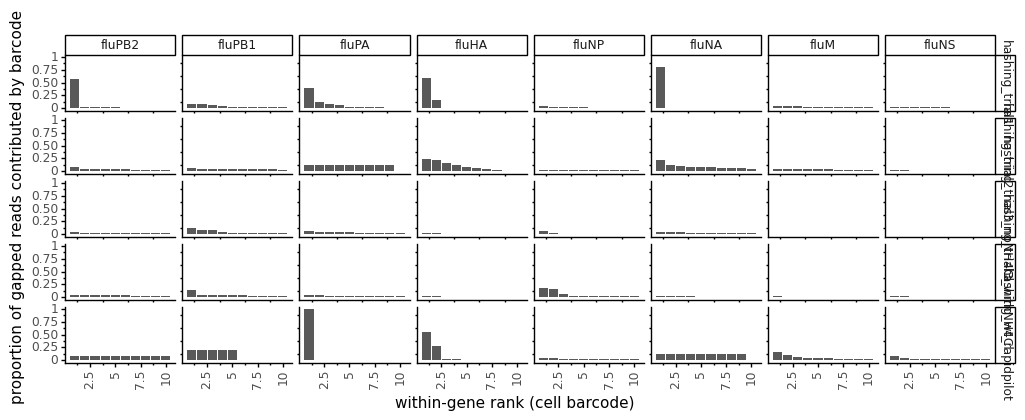

In [26]:
p = (ggplot(gapped_reads_summary_filtered, aes('cell_bc_sort', 'nreads_prop_by_gene')) +
     geom_bar(stat="identity") +
     facet_grid('sample ~ gene') +
     theme(figure_size=(1.5*len(gapped_reads_summary['gene'].unique()), 4),
           axis_text_x=element_text(angle=90)) +
     labs(x="within-gene rank (cell barcode)", y = "proportion of gapped reads contributed by barcode")
    )

_ = p.draw()